In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

Wed Nov  3 19:42:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   33C    P0    37W / 300W |     10MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   33C    P0    39W / 300W |     10MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding =4), #cifar 10 image size : 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train=True, 
                download= True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                download=True, transform= transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96,
                                         shuffle =True, num_workers =2)

#num_workers =2 인지 4인지 or batch_size test의 경우는 왜 100인지?

Files already downloaded and verified
Files already downloaded and verified


### Using ReLU6 in Block

In [10]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [13]:
class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [14]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda':
#     net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [17]:
# net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.045
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

loss_list = []
accuracy_list=[]

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)#예측값과 실제 타깃값
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    accuracy_list.append(100. * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    loss_list.append(loss)
    print('Test average loss:', loss / total)    

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


        
#learning rate를 바꾸기
def adjust_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch <=150 and epoch != 0:
            param_group['lr'] = lr * 0.98
        print(param_group['lr'])

In [18]:
for epoch in range(0, 150):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

0.045

[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.5625
Current benign train loss: 1.2119487524032593

Current batch: 100
Current benign train accuracy: 0.625
Current benign train loss: 1.079217553138733

Current batch: 200
Current benign train accuracy: 0.6458333333333334
Current benign train loss: 0.9185301661491394

Current batch: 300
Current benign train accuracy: 0.6979166666666666
Current benign train loss: 0.8974875807762146

Current batch: 400
Current benign train accuracy: 0.7291666666666666
Current benign train loss: 0.722384512424469

Current batch: 500
Current benign train accuracy: 0.75
Current benign train loss: 0.6864789128303528

Total benign train accuarcy: 64.51
Total benign train loss: 524.3971230983734

[ Test epoch: 0 ]

Test accuarcy: 67.2
Test average loss: 0.009961682322621346
Model Saved!
0.0441

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.8020833333333334
Current benign train loss: 0.6685884594917297

Current


Current batch: 300
Current benign train accuracy: 0.8229166666666666
Current benign train loss: 0.5676093697547913

Current batch: 400
Current benign train accuracy: 0.9375
Current benign train loss: 0.2480641007423401

Current batch: 500
Current benign train accuracy: 0.8541666666666666
Current benign train loss: 0.43760648369789124

Total benign train accuarcy: 86.922
Total benign train loss: 195.49374368786812

[ Test epoch: 9 ]

Test accuarcy: 84.9
Test average loss: 0.004738012245297432
Model Saved!
0.036768276309939604

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.3481258153915405

Current batch: 100
Current benign train accuracy: 0.7916666666666666
Current benign train loss: 0.5216249227523804

Current batch: 200
Current benign train accuracy: 0.875
Current benign train loss: 0.4352787435054779

Current batch: 300
Current benign train accuracy: 0.84375
Current benign train loss: 0.4067021906375885

Current 


Current batch: 500
Current benign train accuracy: 0.8645833333333334
Current benign train loss: 0.3282844126224518

Total benign train accuarcy: 91.628
Total benign train loss: 124.64764079451561

[ Test epoch: 18 ]

Test accuarcy: 88.55
Test average loss: 0.003763842262327671
Model Saved!
0.030655468090795137

[ Train epoch: 19 ]

Current batch: 0
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.09497183561325073

Current batch: 100
Current benign train accuracy: 0.9375
Current benign train loss: 0.2124350219964981

Current batch: 200
Current benign train accuracy: 0.9375
Current benign train loss: 0.25135093927383423

Current batch: 300
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.2824408710002899

Current batch: 400
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.2927292585372925

Current batch: 500
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.28549495339


Total benign train accuarcy: 94.04
Total benign train loss: 87.14666257053614

[ Test epoch: 27 ]

Test accuarcy: 89.79
Test average loss: 0.0035993452958762648
Model Saved!
0.02555892791775266

[ Train epoch: 28 ]

Current batch: 0
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.21355986595153809

Current batch: 100
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.19247053563594818

Current batch: 200
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.1556994765996933

Current batch: 300
Current benign train accuracy: 0.9375
Current benign train loss: 0.18744783103466034

Current batch: 400
Current benign train accuracy: 0.96875
Current benign train loss: 0.06682109087705612

Current batch: 500
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.20440177619457245

Total benign train accuarcy: 94.214
Total benign train loss: 84.55268259719014

[ Test epoch: 28 ]

Test ac


Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.023538559675216675

Current batch: 100
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.10241109132766724

Current batch: 200
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05998862907290459

Current batch: 300
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.14259259402751923

Current batch: 400
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.1315733790397644

Current batch: 500
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.1073390543460846

Total benign train accuarcy: 96.002
Total benign train loss: 57.975896993651986

[ Test epoch: 37 ]

Test accuarcy: 90.19
Test average loss: 0.0037788264788687228
Model Saved!
0.020883504974794645

[ Train epoch: 38 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign


Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.028823859989643097

Current batch: 200
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.06733528524637222

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.058777082711458206

Current batch: 400
Current benign train accuracy: 0.96875
Current benign train loss: 0.09122852236032486

Current batch: 500
Current benign train accuracy: 0.96875
Current benign train loss: 0.124196857213974

Total benign train accuarcy: 97.09
Total benign train loss: 42.85078625846654

[ Test epoch: 46 ]

Test accuarcy: 90.84
Test average loss: 0.003765044614672661
Model Saved!
0.017411575538168883

[ Train epoch: 47 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.04821548983454704

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.08559566736221313

Cur


Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.11388357728719711

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.044970203191041946

Current batch: 500
Current benign train accuracy: 0.96875
Current benign train loss: 0.09109821915626526

Total benign train accuarcy: 98.076
Total benign train loss: 28.911976650357246

[ Test epoch: 55 ]

Test accuarcy: 91.33
Test average loss: 0.003939397075772286
Model Saved!
0.01451686214010837

[ Train epoch: 56 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0076452940702438354

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.039424918591976166

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.1413918137550354

Current batch: 300
Current benign train accuracy: 0.96875
Current benign train loss: 0.10369063168764114



Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.008395032025873661

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.03687495365738869

Total benign train accuarcy: 98.642
Total benign train loss: 19.837728417711332

[ Test epoch: 64 ]

Test accuarcy: 91.05
Test average loss: 0.004081977932155132
Model Saved!
0.012103401322467249

[ Train epoch: 65 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.06662490963935852

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.042090948671102524

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.010778497904539108

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.015065975487232208

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.07254648208618164

Current batch: 5


Test accuarcy: 91.49
Test average loss: 0.0041621376603841785
Model Saved!
0.010091183766770163

[ Train epoch: 74 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.010605682618916035

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.020423466339707375

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.008586443960666656

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0021319950465112925

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0017973707290366292

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0015348400920629501

Total benign train accuarcy: 99.254
Total benign train loss: 11.835653096903116

[ Test epoch: 74 ]

Test accuarcy: 91.63
Test average loss: 0.0042736962389200925
Model Saved!
0.009889360091434759

[ Train epoch: 75 ]

Current batch: 0
Current ben


Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.026571139693260193

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.006530238781124353

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0013807420618832111

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.02012876234948635

Total benign train accuarcy: 99.472
Total benign train loss: 8.107478418474784

[ Test epoch: 83 ]

Test accuarcy: 91.78
Test average loss: 0.004532506875693798
Model Saved!
0.008245231845132941

[ Train epoch: 84 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.03577309474349022

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.020574767142534256

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0031403573229908943

Current batch: 300


Total benign train accuarcy: 99.622
Total benign train loss: 5.886361912838765

[ Test epoch: 92 ]

Test accuarcy: 91.99
Test average loss: 0.004402651178953238
Model Saved!
0.006874443599123835

[ Train epoch: 93 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.020608436316251755

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00643227668479085

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.004542241804301739

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.005501250270754099

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.003381019225344062

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0058264113031327724

Total benign train accuarcy: 99.592
Total benign train loss: 6.425844911747845

[ Test epoch: 93 ]

Test accuarcy: 92.01
Test average loss: 0.004420208


Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.017378874123096466

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.004875844810158014

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.03334839269518852

Total benign train accuarcy: 99.79
Total benign train loss: 3.6101011529099196

[ Test epoch: 102 ]

Test accuarcy: 92.06
Test average loss: 0.004573398185521364
Model Saved!
0.00561692092732624

[ Train epoch: 103 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.004695332143455744

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0023901958484202623

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.009767379611730576

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.002014378784224391

Current batch: 400
Current benign train accurac


Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.036650530993938446

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0010991223389282823

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0018785828724503517

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.015307590365409851

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0003884584584739059

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.006048564333468676

Total benign train accuarcy: 99.834
Total benign train loss: 2.659211162434076

[ Test epoch: 112 ]

Test accuarcy: 92.5
Test average loss: 0.0045499112226068976
Model Saved!
0.004589433348155853

[ Train epoch: 113 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00020553417562041432

Current batch: 100
Current b


Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0014752718852832913

Total benign train accuarcy: 99.912
Total benign train loss: 1.751572491531988

[ Test epoch: 121 ]

Test accuarcy: 92.38
Test average loss: 0.004771489301789552
Model Saved!
0.0038264297834704228

[ Train epoch: 122 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0007558410870842636

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0019015517318621278

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.028507264330983162

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00101680017542094

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.01100910734385252

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0013871798291802406

Total benign train accuarcy:


Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00611130939796567

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0018252964364364743

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.01566935144364834

Total benign train accuarcy: 99.904
Total benign train loss: 1.7389334080908156

[ Test epoch: 131 ]

Test accuarcy: 92.36
Test average loss: 0.0046768349481746555
Model Saved!
0.003126471723538286

[ Train epoch: 132 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.004112116526812315

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0009966777870431542

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.004180640447884798

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0003693374164868146

Current batch: 400
Current benign train acc


Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0008795480243861675

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0028505006339401007

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0006625461974181235

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0010314775863662362

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.001149719930253923

Total benign train accuarcy: 99.938
Total benign train loss: 1.1204907274986908

[ Test epoch: 141 ]

Test accuarcy: 92.63
Test average loss: 0.004763485332950949
Model Saved!
0.0025545550268059737

[ Train epoch: 142 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.001115518738515675

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.000534030725248158

Current batch: 200
Current benign train accuracy: 1.0
C

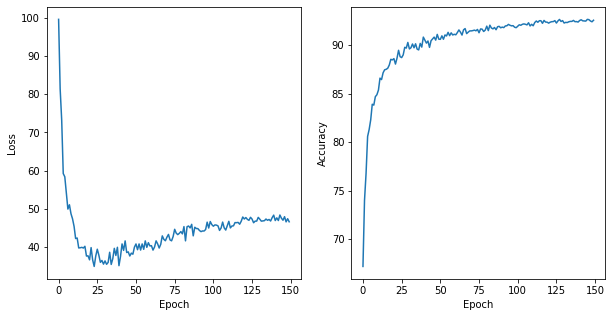

In [19]:
epochs = np.arange(0,150)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.plot(epochs,loss_list) 
plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(epochs, accuracy_list) 
plt.show()